# Model Based Machine Learning

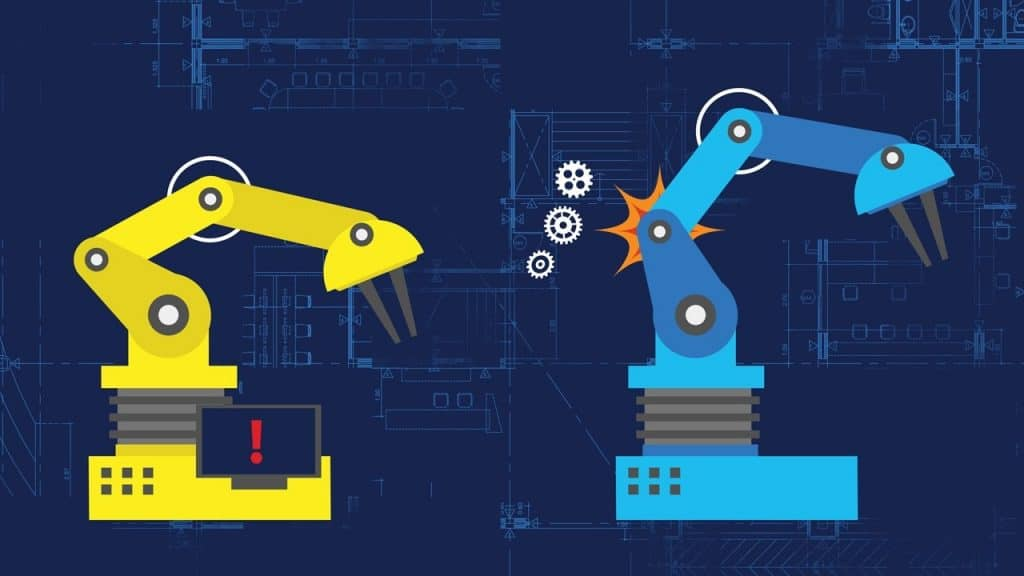

In [21]:
from IPython import display
display.Image("https://www.analyticsinsight.net/wp-content/uploads/2021/01/Predictive-Maintainance-1024x576.jpg")

In [22]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline

#matplotlib style options
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 8)

# Loading data from the different sources

In order to build our predictive maintenance system, we will consider data from 5 sources:

* Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.
* Error history: The history of error codes from the machine.
* Maintenance history: The repair history of a machine, e.g. previous maintenance activities or component replacements.
* Machine features: The features of a machine, e.g. engine size, make and model, location.
* Failure history: The failure history of a machine or component within the machine.

The raw data from these sources was already pre-processed, and relevant features were extracted from it in order to be used in this notebook.

In [23]:
# load data from csv
telemetry = pd.read_csv('IBA/telemetry.csv')

# format datetime field which comes in as string
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
telemetry.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,15.726970,39.648116,11.904700,5.601191
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,15.635083,41.828592,11.326412,5.583521
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.995465,40.843882,11.036546,5.561553
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.100364,43.409841,10.972862,6.068674
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.808489,43.742304,10.988704,7.286129


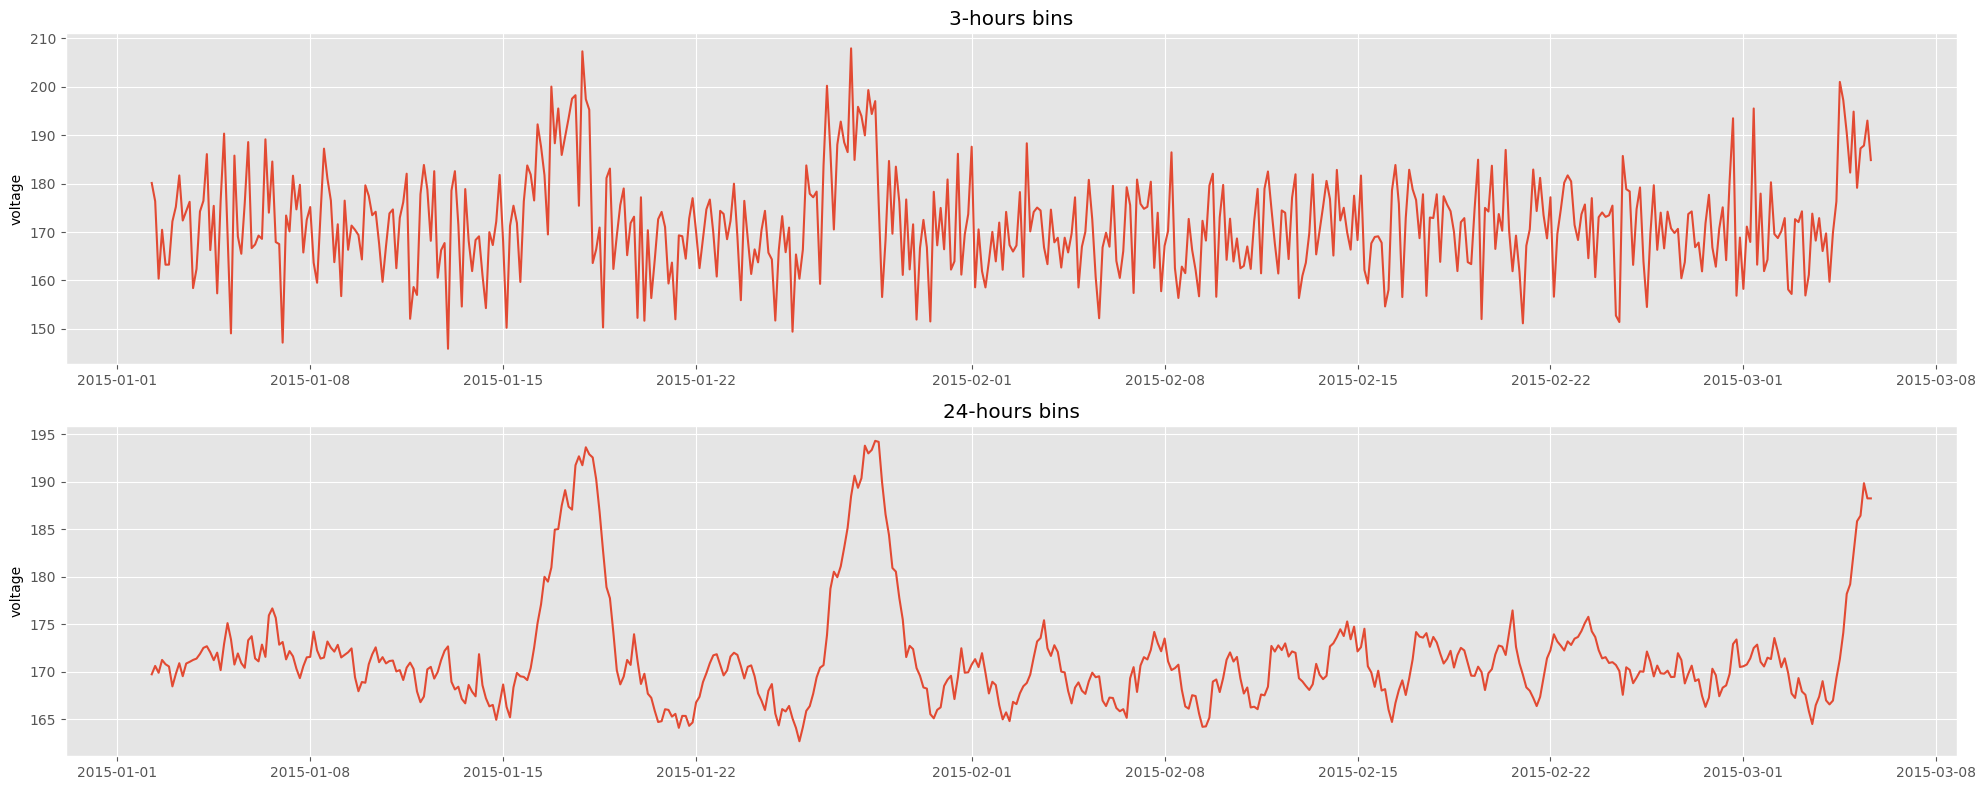

In [24]:
# plot voltage data (3-hour bins) and (24-hour bins)
fig, axs = plt.subplots(2, sharey='row', figsize=(20,8))

axs[0].plot(telemetry[telemetry['machineID'] == 1][:500]['datetime'], telemetry[telemetry['machineID'] == 1][:500]['voltmean_3h'], )
axs[0].set_title("3-hours bins")
axs[0].set_ylabel('voltage')

axs[1].plot(telemetry[telemetry['machineID'] == 1][:500]['datetime'], telemetry[telemetry['machineID'] == 1][:500]['voltmean_24h'], )
axs[1].set_title("24-hours bins")
axs[1].set_ylabel('voltage')

plt.tight_layout()

### Maintenance data

In [ ]:
# load data from csv
comp_rep = pd.read_csv('IBA/comp_rep.csv')

# format datetime field which comes in as string
comp_rep['datetime'] = pd.to_datetime(comp_rep['datetime'], format="%Y-%m-%d %H:%M:%S")

# show first rows
comp_rep.head()

In [ ]:
df = comp_rep[(comp_rep['machineID']==1)][['datetime','comp1','comp2','comp3','comp4']]

In [ ]:
df.head()

In [ ]:
for comp in ['comp1','comp2','comp3','comp4']:
    df[comp] = df.apply(lambda row: row['datetime'] if row[comp]==0 else np.nan, axis=1)

In [ ]:
df

In [ ]:
df[df['zero'].isna()==False].index

In [ ]:
for comp in ['comp1','comp2','comp3','comp4']:
    df[comp].fillna(method='backfill', inplace=True)

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

In [ ]:
for comp in ['comp1','comp2','comp3','comp4']:
    df[comp] = df[comp] - df['datetime']

In [ ]:
for comp in ['comp1','comp2','comp3','comp4']:
    df[comp] = df[comp].apply(lambda row: row.total_seconds()/86400)

In [ ]:
df

In [ ]:
# visualize days since last component replacement
df.plot(x='datetime', y=['comp1','comp2','comp3','comp4'], figsize=(20,8))
plt.ylabel("days until component's replacement")
plt.show()